# Classification & FeatureExtraction
Applicheremo diversi algoritmi classici di Machine Learning (*SVM*, *k-NN*, *Random Forest* e *AdaBoost*) a un problema di classificazione binario di **immagini RGB** raffiguranti cani e gatti.

Al fine di manipolare e adattare le immagini verranno utilizzate alcune funzionalità messe a disposizione dalla libreria **Scikit-image**. 

# Scikit-image
Scikit-image è una libreria Python che mette a disposizione numerose classi e funzionalità per l'elaborazione di immagini.

Condivide con Scikit-learn la facilità d'uso, l'ampia possibilità di parametrizzare le operazioni messe a disposizione e l'integrazione con la libreria Numpy. Allo stesso modo lo stile della documentazione e della API è estremamente simile a quello di Scikit-learn.

Per una lista completa delle funzionalità si rimanda alla [documentazione ufficiale](http://scikit-image.org/docs/stable/).

# Import delle librerie
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione. Il modulo necessario per utilizzare la libreria Scikit-image si chiama **skimage**.

In [ ]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from joblib import Memory
from skimage import feature, color, transform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import ml_utilities
import ml_visualization

# Caricamento del dataset
Il dataset consiste in un insieme di immagini RGB di cani e gatti. Prima di caricarlo è necessario definire:
- il percorso in cui sono memorizzate le immagini dei dataset (*db_path*);
- il percorso di una cartella di lavoro (*exp_path*) dove, durante l'elaborazione, saranno memorizzati file intermedi;
- il path del file contenente la lista delle immagini e relative etichette di classe da utilizzare come training set (*train_filelist*).

Caricamento in corso ...
Caricate 900 immagini in 0.17 s.
Gatti: 509
Cani: 391


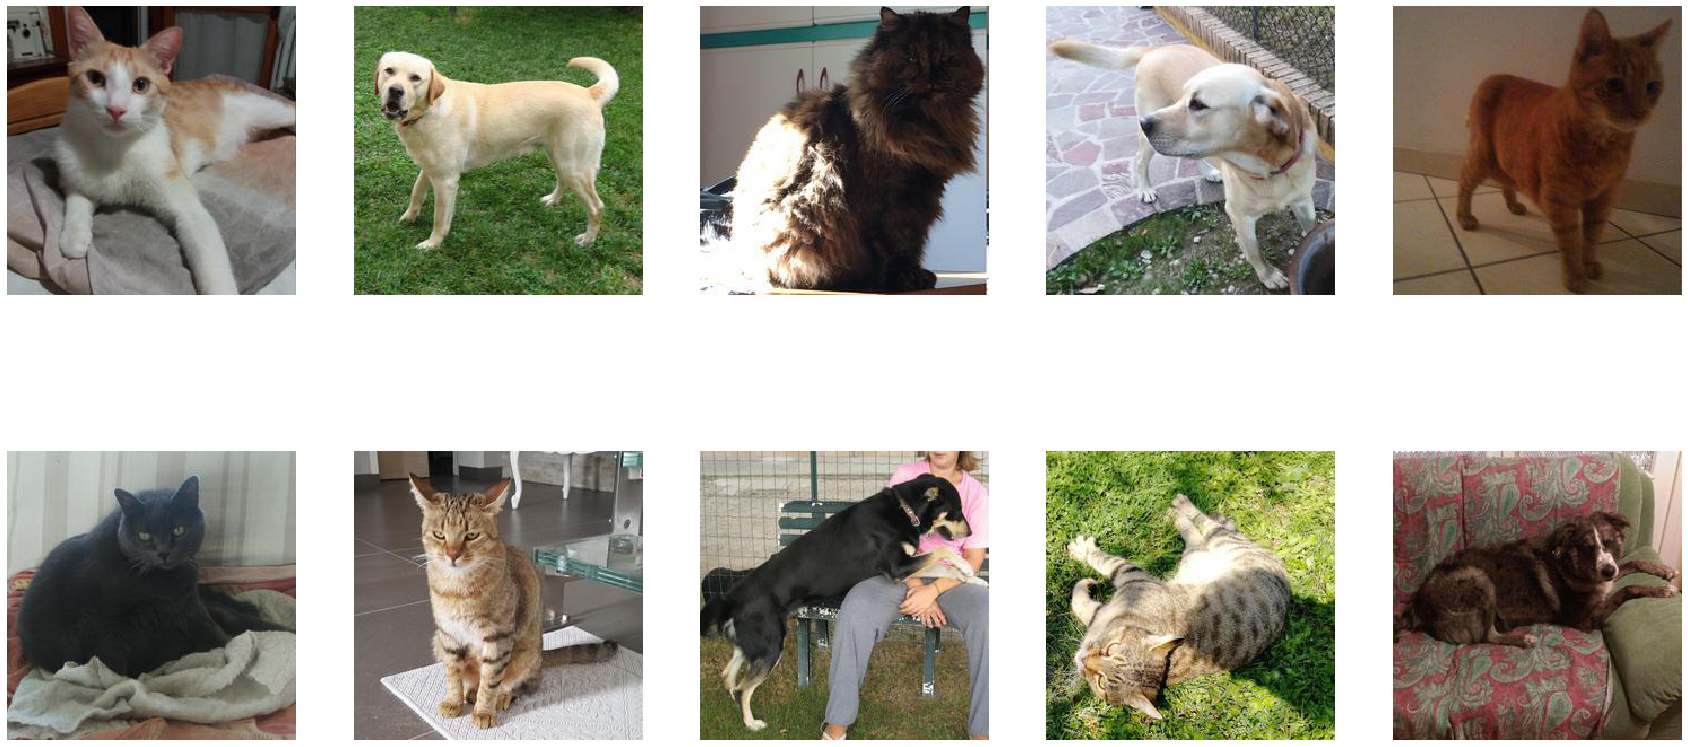

In [ ]:
db_path = 'DBs/CaniGatti_ML18'
exp_path = 'Experiments'
train_filelist = 'BinaryTrainingSet.txt'  

# Predisposizione di un'area di caching su disco che velocizza la riesecuzione di chiamate di funzioni con gli stessi parametri
memory = Memory(exp_path, verbose=0)  

# Caricamento delle immagini
print('Caricamento in corso ...')
start = time.time()
train_raw_x, train_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)

print('Caricate %d immagini in %.2f s.' % (len(train_raw_x), time.time() - start))
print('Gatti:', np.count_nonzero(train_y == 0))
print('Cani:', np.count_nonzero(train_y == 1))

# Shuffle del training set
ml_utilities.shuffle_in_unison([train_raw_x, train_y], seed=1234)

# Visualizzazione immagini
_, axs = plt.subplots(2, 5,figsize=(30, 15))
for i in range(5):
    axs[0,i].imshow(train_raw_x[i]),axs[0,i].axis('off')
    axs[1,i].imshow(train_raw_x[5+i]),axs[1,i].axis('off')
plt.show()

Se le dimensioni delle immagini in input sono eterogenee, prima di poterle utilizzare è necessario portarle tutte a delle dimensioni prefissate ($\textit{image_side} \times \textit{image_side}$) come mostrato nella cella seguente.

Resizing in corso ...
Resizing completato in 0.39 s.


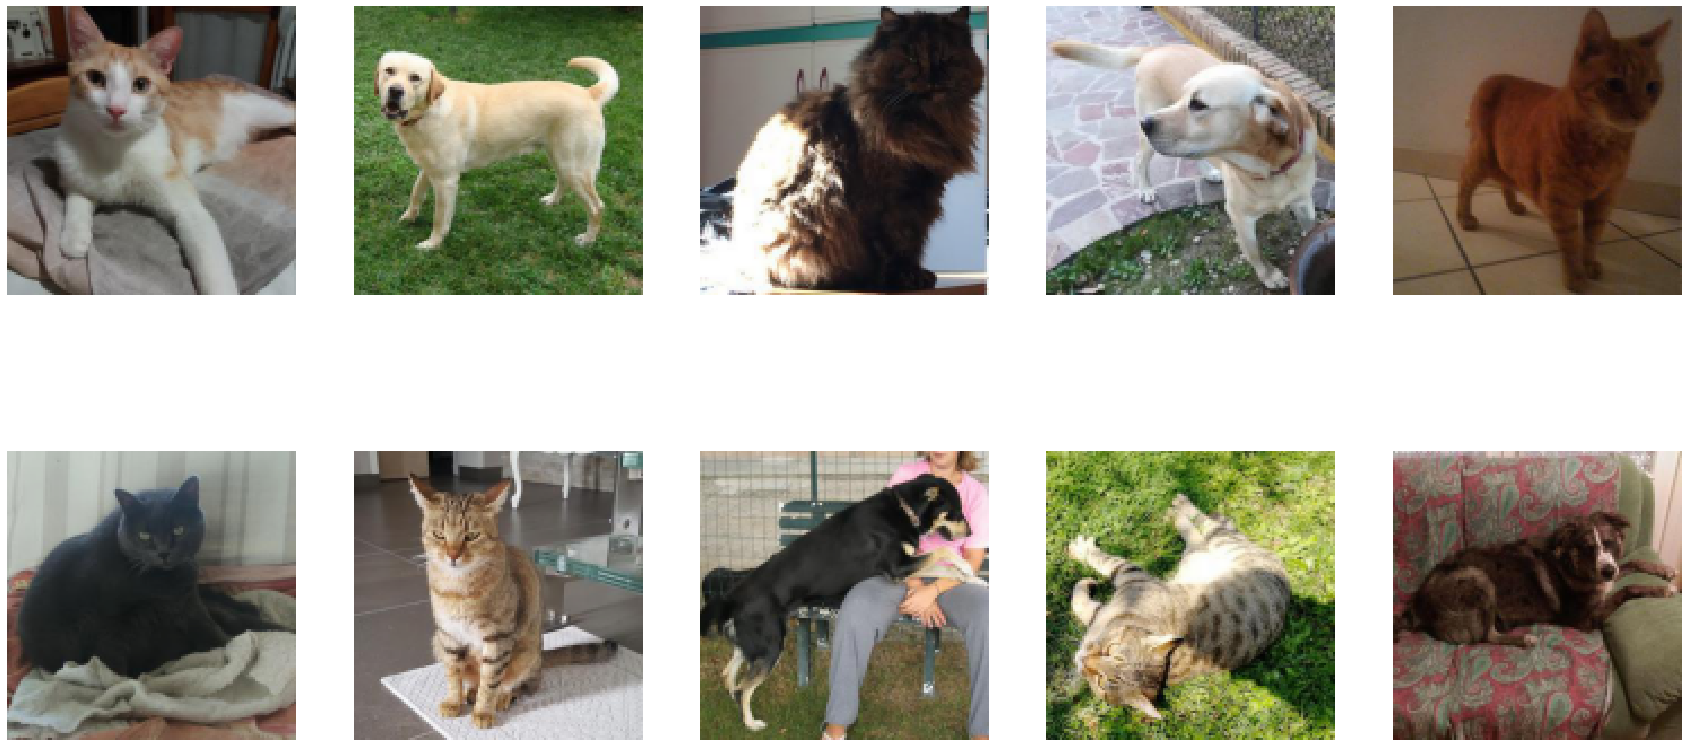

In [ ]:
resizing = True
image_side = 128

if resizing:
    # Resize
    print('Resizing in corso ...')
    start = time.time()
    train_raw_x = ml_utilities.resize_images(train_raw_x, image_side, image_side, cache=memory)
    
    print('Resizing completato in %.2f s.' % (time.time() - start))
    
    # Visualizzazione immagini
    _, axs = plt.subplots(2, 5,figsize=(30, 15))
    for i in range(5):
        axs[0,i].imshow(train_raw_x[i]),axs[0,i].axis('off')
        axs[1,i].imshow(train_raw_x[5+i]),axs[1,i].axis('off')
    plt.show()

# Classificazione a partire dai pixel

Le immagini ottenute (anche a seguito di *resizing*) sono molto grandi per poter essere utilizzate direttamente come input di un classificatore tradizionale. Infatti un'immagine $\textit{128} \times \textit{128} \times \textit{3}$ corrisponde a un pattern 49152-dimensionale.

Utilizzando un *SVM* il tempo di training è di circa 2 minuti (utilizzando la classe **LinearSVC** ottimizzata per *kernel* lineare) per ottenere un'accuratezza intorno al 57% (di poco superiore alla scelta casuale!).

Nel settore della visione artificiale per l'addestramento di classificatori (qualora non si utilizzino tecniche di deep learning quali le reti CNN) è prassi consolidata estrarre dalle immagini feature **robuste** e **compatte**.

Perchè l'intensità dei pixel non è una feature robusta?
<img src="pixel_dist.png" alt="" style="width: 600px;"/>

Variazioni di posa, e illuminazione possono rendere campioni della stessa classe molto diversi tra loro in termini di intensità di pixel corrispondenti.

Purtroppo non esiste un tipo di feature idoneo per tutti i problemi ma è necessario padroneggiare il dominio applicativo per scegliere/progettare in modo ottimale le feature da utilizzare (si parla di *feature engineering* o *handcrafted features*).

# Estrazione delle feature (HOG)
Utilizzeremo le feature note come *Histogram of Oriented Gradients* ([HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)), originariamente introdotte per *pedestrian detection*, ma applicabili anche ad altri domini.

Un'implementazione è disponibile nella libreria  [Scikit-image](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog).

Per estrarre le orientazioni, il metodo HOG non ha evidenti vantaggi dall'uso del colore. Pertanto prima dell'estrazione le immagini possono essere convertite da RGB (3 byte per pixel) in scala di grigi (1 byte per pixel).

L'immagine viene suddivida in blocchi. Per ognuno di essi HOG estrae le orientazioni del gradiente e le riassume attraverso un istogramma. 

La funzione **hog(...)** restituisce un **ndarray** monodimensionale contenente le feature estratte. Con il paramentro opzionale (*visualise*) è possibile ottenerne una visualizzazione grafica utile per comprendere meglio la natura delle feature estratte. La cella seguente visualizza una rappresentazione HOG relativa a un'immagine di esempio.

Numero feature: 3240


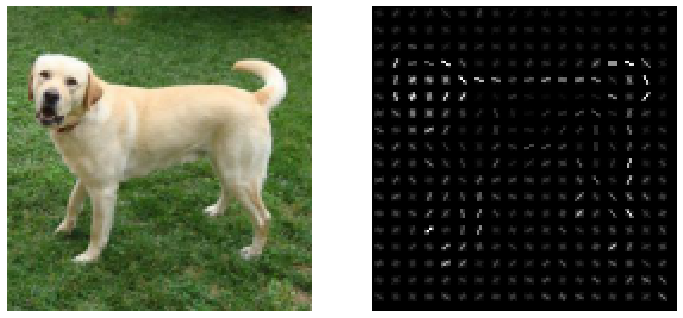

In [ ]:
image_index = 1  # Modificare con un indice a piacere

# Conversione in grayscale
grayscale_image = color.rgb2gray(train_raw_x[image_index])  

# Estrazione delle feature
hog_features, hog_image = feature.hog(grayscale_image,
                                      orientations=10, pixels_per_cell=(7, 7),
                                      cells_per_block=(1, 1),  block_norm='L2-Hys',
                                      visualize=True)  

print('Numero feature:', len(hog_features))

# Visualizzazione HOG
_, axs = plt.subplots(1, 2,figsize=(12, 6))
axs[0].imshow(train_raw_x[image_index]),axs[0].axis('off')
axs[1].imshow(hog_image),axs[1].axis('off')
plt.show()

La procedura appena descritta deve essere applicata a tutte le immagini. Per fare ciò è possibile utilizzare la funzione **extract_hog(...)** del modulo *ml_utilities* come mostrato di seguito:

In [ ]:
print('Estrazione delle feature HOG in corso ...')
start = time.time()
train_feature_x = ml_utilities.extract_hog(train_raw_x, 
                                           convert_to_gray=True, orientations=14,
                                           pixels_per_cell=(6, 6), cells_per_block=(4, 4),
                                           cache=memory)
print('Estrazione completata in %.2f s.' % (time.time() - start))
# tutti quanti valori tra 0 e 1
# print(list(train_feature_x))
# 900 pattern di train
# print(len(train_feature_x))
# ogni pattern ha 2304 feature (dimensioni)
print(train_feature_x[0].shape)

Estrazione delle feature HOG in corso ...
Estrazione completata in 9.40 s.
(72576,)


# Addestramento del classificatore
Completata la fase di **estrazione** delle feature, è possibile utilizzarle per addestrare un classificatore.

Il dataset *train_feature_x* e la lista delle etichette di classe *train_y* sono nel formato richiesto dall'API di Scikit-learn.

In Scikit-learn oltre a [*k-NN*](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) e [*SVM*](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (visti nell'esercitazione precedente) sono presenti anche i classificatori [*Random Forest*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) e [*AdaBoost*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). 

Di seguito vengono riportate le istruzioni necessarie per creare e addestrare un classificatore:

In [ ]:
start = time.time()
# clf = KNeighborsClassifier()
# clf = SVC()
# clf = RandomForestClassifier(random_state=1234)
clf = AdaBoostClassifier(random_state=1234)

print('Addestramento in corso ...')
clf.fit(train_feature_x, train_y)
print('Addestramento completato in %.2f s.' % (time.time() - start))

È possibile stimare l'accuratezza di un classificatore utilizzando il metodo **.predict(...)**. Il metodo restituisce le predizioni del classificatore su un insieme di pattern che, confrontate con le etichette reali, permettono di calcolarne l'accuratezza. Ad esempio:

In [ ]:
print('Valutazione sul training set in corso ...')
start = time.time()
train_predictions = clf.predict(train_feature_x)
print('Valutazione sul training set completata in %.2f s.' % (time.time() - start))

# Calcolo accuratezza
train_accuracy = (train_predictions == train_y).sum()/len(train_y)
print('Accuratezza:', train_accuracy)

# Visualizzazione Confusion Matrix
ml_visualization.plot_confusion_matrix(train_y, train_predictions, ['Cat', 'Dog'])

# Esercizio
L'obiettivo è massimizzare l'accuratezza di classificazione, valutando (con *Cross-Validation*):
- l'impiego dei classificatori: [*k-NN*](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [*SVM*](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [*Random Forest*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) e [*AdaBoost*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html);
- l'ottimizzazione dei relativi iperparametri;
- l'ottimizzazione dei parametri utilizzati per estrarre le feature HOG;
- la combinazione di più classificatori.

In [ ]:
X_train_new, X_val, y_train_new, y_val = \
    train_test_split(train_feature_x, train_y, test_size=0.4, random_state=42) 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


clf1 = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', n_estimators=1800)

clf2 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(C=6.06, probability=True, decision_function_shape='ovo', gamma='scale', kernel='rbf', random_state=42))
])


eclf1 = VotingClassifier(estimators=[('rf', clf1), ('svc', clf2)], voting='soft')

eclf1.fit(X_train_new, y_train_new)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=1800,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('svc',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('clf',
                                               SVC(C=6.06,
                                                   decision_function_shape='ovo',
                                                   probability=True,
                                                   random_state=42))]))],
                 voting='soft')

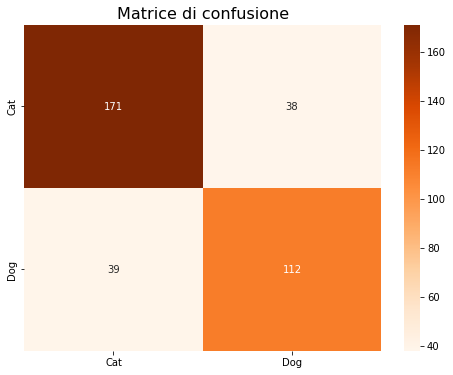

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

plt.figure(figsize=(8, 6))
plt.title('Matrice di confusione', size=16)
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, eclf1.predict(X_val)), columns=['Cat', 'Dog'], index = ['Cat', 'Dog']), 
            annot=True, cmap='Oranges', fmt='d');


In [ ]:
# Path contenente i pattern di test
image_side = 128
db_path = 'DBs/CaniGatti_ML18'
exp_path = 'Experiments'
train_filelist = 'BinaryTrainingSet.txt' 
test_filelist = 'Unlabeled_BinaryTestSet.txt'
result_path = 'Es4Predictions.txt'
memory = Memory(exp_path, verbose=0) 

# Caricamento dei pattern di training
# Predisposizione di un'area di caching su disco che velocizza la riesecuzione di chiamate di funzioni con gli stessi parametri
memory = Memory(exp_path, verbose=0)  

# Caricamento delle immagini
print('Caricamento in corso ...')
start = time.time()
train_raw_x, train_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)

# Shuffle del training set
ml_utilities.shuffle_in_unison([train_raw_x, train_y], seed=42)


# Preprocessing ed estrazione HOG (training)
resizing = True
image_side = 128

if resizing:
    # Resize
    print('Resizing in corso ...')
    start = time.time()
    train_raw_x = ml_utilities.resize_images(train_raw_x, image_side, image_side, cache=memory)
    
    print('Resizing completato in %.2f s.' % (time.time() - start))

    
print('Estrazione delle feature HOG in corso ...')
start = time.time()
train_feature_x = ml_utilities.extract_hog(train_raw_x, 
                                           convert_to_gray=True, orientations=14,
                                           pixels_per_cell=(6, 6), cells_per_block=(4, 4),
                                           cache=memory)
print('Estrazione completata in %.2f s.' % (time.time() - start))



# Creazione del classificatore
clf1 = RandomForestClassifier(n_jobs=-1, random_state=42, criterion='gini', n_estimators=1800)

clf2 = Pipeline([
    ('clf', SVC(C=6.06, probability=True, decision_function_shape='ovo', gamma='scale', kernel='rbf', random_state=42))
])

eclf1 = VotingClassifier(estimators=[('rf', clf1), ('svc', clf2)], voting='soft')

# Addestramento del classificatore
eclf1.fit(train_feature_x, train_y)

# Caricamento dei pattern di test
test_raw_x = ml_utilities.load_unlabeled_dataset(test_filelist, db_path, cache=memory)

# Preprocessing ed estrazione HOG (test)
resizing = True
image_side = 128

if resizing:
    # Resize
    print('Resizing in corso ...')
    start = time.time()
    test_raw_x = ml_utilities.resize_images(test_raw_x, image_side, image_side, cache=memory)
    
    print('Resizing completato in %.2f s.' % (time.time() - start))

    
print('Estrazione delle feature HOG in corso ...')
start = time.time()
test_feature_x = ml_utilities.extract_hog(test_raw_x, 
                                           convert_to_gray=True, orientations=14,
                                           pixels_per_cell=(6, 6), cells_per_block=(4, 4),
                                           cache=memory)
print('Estrazione completata in %.2f s.' % (time.time() - start))

# Salvataggio delle predictions
predictions = eclf1.predict(test_feature_x)

with open(result_path, "w") as f:
    for prediction in predictions:
        f.write(str(int(prediction)) + '\n')
print('Ok')

Caricamento in corso ...
Resizing in corso ...
Resizing completato in 0.40 s.
Estrazione delle feature HOG in corso ...
Estrazione completata in 9.88 s.
Resizing in corso ...
Resizing completato in 0.06 s.
Estrazione delle feature HOG in corso ...
Estrazione completata in 1.71 s.
Ok
